# Neural net and flipped polarity classification

We use ML to classify the polarity $(\pm 1)$ of seismic traces. Each trace corresponds to a hydrophone which listens for sound wave reflecting from the geology in the subsurface of the Earth. The sound waves have "shots" as their sources. These shots are denotations set off above the ground.

Sometimes the channel arrays have geophones which are recording data with a phase inversion of -1. That is, they record -f(t) when they should be recording f(t). To process seismic data into a tomographic image, these flipped polarity traces need to be identified.

This open source seismic data comes with channels that have this error. We use a nearest-neighbors algorithm to catalog them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

## Reading in and cleaning the data

In [2]:
raw_data = pd.read_csv('/Users/cabrera/Documents/10_python_coding/550_seismic_trace_polarity/seismic_traces.txt',header=None,skiprows=[0])

The data is being read as series:

In [4]:
raw_data.shape

(5391360, 1)

But each datapoint is made up of 51 attributes and a target label $(\pm 1)$, so we need to reorganize:

In [5]:
raw_data.head(5)

,0
0,channel=1 shot=2372 label=-1
1,0 1.35109469e-01
2,1 -1.49369106e-01
3,2 1.57715330e+01
4,3 1.42361059e+01


In [3]:
def series_to_dataframe(series,length,sample):
    #function to convert series to dataframe such that entries
    #within [sample_i,sample_(i+52), i % sample = 0, are mapped to a column
    #length = total entries from series to be mapped to the dataframe
    
    df = pd.DataFrame(index=range(0,sample+1))

    for x in range(0,int(length),sample): #for production len(df), or len(df)/2
        df[x] = pd.Series(series.iloc[x:x+53,0].reset_index()[0])
       
    return df

In [4]:
traces_df = series_to_dataframe(raw_data, len(raw_data)/2, 52)

traces_df.head()

,0,52,104,156,208,260,312,364,416,468,...,2695160,2695212,2695264,2695316,2695368,2695420,2695472,2695524,2695576,2695628
0,channel=1 shot=2372 label=-1,channel=9 shot=2372 label=1,channel=17 shot=2372 label=1,channel=25 shot=2372 label=1,channel=33 shot=2372 label=1,channel=41 shot=2372 label=-1,channel=49 shot=2372 label=1,channel=57 shot=2372 label=1,channel=65 shot=2372 label=1,channel=73 shot=2372 label=1,...,channel=2225 shot=6668 label=1,channel=2233 shot=6668 label=1,channel=2241 shot=6668 label=-1,channel=2249 shot=6668 label=1,channel=2257 shot=6668 label=1,channel=2265 shot=6668 label=1,channel=2273 shot=6668 label=1,channel=2281 shot=6668 label=-1,channel=2289 shot=6668 label=1,channel=2297 shot=6668 label=1
1,0 1.35109469e-01,0 1.45933300e-01,0 -6.92833722e-01,0 -5.48514366e-01,0 -5.12570068e-02,0 -8.86980057e-01,0 -1.76063627e-01,0 2.22643271e-01,0 1.17118979e+00,0 5.71239889e-01,...,0 -5.05644798e+01,0 -5.35335121e+01,0 5.16573334e+01,0 -6.36245384e+01,0 -6.22858963e+01,0 -6.69708176e+01,0 -6.17421837e+01,0 4.24557686e+01,0 -3.49117241e+01,0 -3.27148094e+01
2,1 -1.49369106e-01,1 1.75313914e+00,1 1.99631679e+00,1 3.04945016e+00,1 2.88342237e+00,1 -1.33383894e+00,1 1.71477425e+00,1 1.66236949e+00,1 2.14069176e+00,1 1.45541644e+00,...,1 -2.43941898e+01,1 -2.50681992e+01,1 1.98644161e+01,1 -2.24622288e+01,1 -1.41626024e+01,1 -1.40747652e+01,1 -7.30249357e+00,1 1.30712271e+01,1 -8.87607956e+00,1 -1.96998653e+01
3,2 1.57715330e+01,2 -1.49585085e+01,2 -2.35901699e+01,2 -2.49880772e+01,2 -3.32448540e+01,2 2.98935757e+01,2 -3.22538071e+01,2 -2.51346836e+01,2 -1.51347399e+01,2 -5.07944202e+00,...,2 -2.13396549e+01,2 -1.86809387e+01,2 2.29194832e+01,2 -1.65655098e+01,2 -2.28135605e+01,2 -2.79594479e+01,2 -2.25943642e+01,2 3.03915577e+01,2 -2.37743130e+01,2 -2.82103367e+01
4,3 1.42361059e+01,3 -1.81383457e+01,3 -1.35441465e+01,3 -7.66792870e+00,3 -1.11441040e+01,3 1.45502367e+01,3 -1.61157742e+01,3 -1.30265388e+01,3 -2.11821022e+01,3 -3.24019890e+01,...,3 -1.31772375e+01,3 -7.91394949e+00,3 2.81915817e+01,3 -2.24558468e+01,3 -3.33276749e+01,3 -3.37345467e+01,3 -2.52948914e+01,3 2.34377728e+01,3 -1.42750978e+01,3 -7.85312891e+00


In [5]:
def select_amplitude(x):
    #function to select the amplitude value from each cell:
    # '2 -2.35901699e+01'  ---> '-2.35901699e+01'
    
    ls = x.split()
    return ls[len(ls)-1]

def pickSign(str):      
    # function to pick send 'gut=-1' ---> -1, 'gut=1' ---> 1
    
    if str[-2:-1]=='-':
        return -1
    else:
        return 1

In [6]:
#Select amplitude value from each cell. 
#Transpose so that the samples of the traces become attributes
data_df = traces_df.applymap(select_amplitude).transpose()

#Create integer target label
data_df['Polarity']= data_df[0].apply(pickSign)
data_df = data_df.drop(labels=[0,52],axis=1)
data_df = data_df.astype('float')

Now we have the data in the shape that we want. Every row corresponds to a data point, with the entries being the samples of the recorded sound waves. The last column contains the polarity label.

In [10]:
data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,Polarity
0,0.135109,-0.149369,15.771533,14.236106,-35.925736,26.909462,-15.012988,1.725460,7.095699,1.463356,...,3.210323,-6.106526,-6.634347,7.872420,6.820869,-4.395456,7.422894,17.544140,3.223560,-1.0
52,0.145933,1.753139,-14.958509,-18.138346,24.836264,-1.771277,6.107979,0.650433,12.429290,-20.766388,...,-6.895596,-2.262812,0.867932,6.583002,-2.523254,1.952146,-1.058738,0.687788,5.562509,1.0
104,-0.692834,1.996317,-23.590170,-13.544147,16.388670,-2.811234,0.292026,19.967159,18.820869,-14.062235,...,5.066412,-4.839576,-7.733660,3.416450,-2.488747,-0.623854,-5.784183,-1.940175,3.148644,1.0
156,-0.548514,3.049450,-24.988077,-7.667929,17.888163,-11.045793,9.761217,11.444410,4.486601,-8.396764,...,8.914586,4.633519,-0.462167,-4.352639,-6.807166,4.047869,5.908732,-9.539698,-5.924528,1.0
208,-0.051257,2.883422,-33.244854,-11.144104,16.647282,-15.133264,21.228491,4.141500,11.930402,-1.909803,...,5.179042,-3.362991,6.316719,8.003730,-8.228494,-1.989292,13.240460,7.562987,-2.874917,1.0


In [11]:
data_df.shape

(51840, 52)

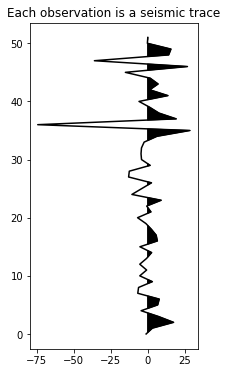

In [113]:
y=np.array(range(len(data_df.loc[0])))
y=np.flip(y)
x=data_df.loc[0]

plt.figure(figsize=(3,6))
plt.plot(x,y,c='k')
plt.fill_betweenx(y,x,0,where=x>0,interpolate=True, color='k')
plt.title('A generic observation is a seismic trace')
plt.show()

## Training/testing split. Resampling the data

We note that the data is umbalanced. So we we address this issue by resampling the number of negative-polarity traces by upsampling this category.

With resampling done we can use `accuracy` as our metric.

In [10]:
print('Number of seismic traces with positive polarity =', len(data_df[data_df.Polarity == 1]))
print('Number of seismic traces with negative polarity =', len(data_df[data_df.Polarity == -1]))

Number of seismic traces with positive polarity = 41400
Number of seismic traces with negative polarity = 10440


In [7]:
#train/test split
X = data_df.drop(labels='Polarity',axis=1)
y = data_df['Polarity']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

**<font color=#3399ff>Should we normalize the attributes?</font>**

In [67]:
# Standardizing the attributes

def standardize(training_set, testing_set):
    #function outputs the same dataframes but features are standardized to 0 mean and unit variance
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(training_set)
    training_scaled = pd.DataFrame(scaler.transform(training_set),index=training_set.index)
    testing_scaled = pd.DataFrame(scaler.transform(testing_set),index=testing_set.index)
    
    return training_scaled, testing_scaled

In [68]:
# Create copy of data with standardized attributes:
X_train_scaled, X_test_scaled = standardize(X_train,X_test)

In [8]:
# Resampling the training dataframes

from sklearn.utils import resample

def resampling(attributes, target, resampling_value, n_samples):
    #function to resample data. attributes = df with attributes, and target = series with target values. 
    #It creates a number of n_samples for those observations
    #corresponding to target == resampling_value.
    
    
    all_data = attributes.copy()
    all_data['target'] = target
    
    print('\n~~~~~~~~~~ Before resampling training data:\n ')
    print('Total number of observations', len(all_data))
    print('Fraction of observations with given label = {length:.2f}'.format(length =len(all_data[all_data.target == resampling_value])/len(all_data)))
    
    #create new samples
    new_samples = resample(all_data[all_data.target == resampling_value],n_samples = n_samples, random_state=0)
    resampled_data = pd.concat([all_data,new_samples])
    
    #Peel off the labels again
    attributes_resampled = resampled_data.drop(labels='target',axis=1)
    target_resampled = resampled_data['target']
    
    print('\n~~~~~~~~~~ After upsampling training data:\n ')
    print('Total number of observations =', len(resampled_data))
    print('Fraction of observations with given label = {frac:.2f}'.format(frac= len(resampled_data[resampled_data.target == resampling_value])/len(resampled_data)) )
   
    return attributes_resampled, target_resampled

In [69]:
#Resampling the standardized training data
X_train_scaled_r, y_train_r = resampling(X_train_scaled,y_train, -1, 23196)


~~~~~~~~~~ Before resampling training data:
 
Total number of observations 38880
Fraction of observations with given label = 0.20

~~~~~~~~~~ After upsampling training data:
 
Total number of observations = 62076
Fraction of observations with given label = 0.50


In [9]:
#Resampling the non-standardized training data
X_train_r, y_train_r = resampling(X_train,y_train,-1,23196)


~~~~~~~~~~ Before resampling training data:
 
Total number of observations 38880
Fraction of observations with given label = 0.20

~~~~~~~~~~ After upsampling training data:
 
Total number of observations = 62076
Fraction of observations with given label = 0.50


#### Baseline of dummy classifier

Sanity check: How do we compare with against dummy classifiers?


In [23]:
from sklearn.dummy import DummyClassifier

dummy_frequent = DummyClassifier(strategy='most_frequent').fit(X_train_r,y_train_r)

print('The most-frequent classifier has accuracy = {score:.2f}'.format(score = dummy_frequent.score(X_test,y_test)))

The most-frequent classifier has accuracy = 0.80


### Other metrics

- In our case, the recall score is the most important one since we care about minimizing _false negatives_ which in our case means minimizing the number of polarity=-1 being labeled as polarity=+1.

- Precision takes a back seat here because erroneously labeling good traces as polarity=-1 only means a few more receivers to QC.

In [61]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
    
def otherScores(model,X_test,y_test):
    #function (1) plots confusion matrix for given model and data
    #         (2) prints recall score
    
    from sklearn.metrics import plot_confusion_matrix
    fig = plot_confusion_matrix(model,X_test,y_test,values_format='d')
    fig.ax_.set_title('Confusion matrix')
    plt.show()
    
    print('\n Recall score = {score:.2f}'.format(score = recall_score(y_test,model.predict(X_test),pos_label=-1)))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

# Using a neural network

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
NNclsf = MLPClassifier(hidden_layer_sizes=(25,), activation='relu',solver='sgd',shuffle=True,random_state=0)

# the activation fn relu(x) = max(0,x) is the most standard activation function. It makes for
# easy to train models and good results

#shuffle means shuffle samples before each iteration

In [34]:
import warnings

def best_model_CV(model,param_space,scoring,X_train,y_train):
    #do GridSearch using desired scoring metric
    #print best parameters
    #return optimized estimator
    
    #suppress warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    
    print("# Tuning parameters for %s" % scoring)
    cvSearch = GridSearchCV(model,param_space,scoring=scoring,cv=3,verbose=1).fit(X_train,y_train)
    print('Best parameters:')
    print()
    print(cvSearch.best_params_)
    print()
    print("Grid scores on parameter set:")
    print()
    means = cvSearch.cv_results_['mean_test_score']
    for mean, params in zip(means, cvSearch.cv_results_['params']):
        print("%0.3f  for %r" % (mean, params))

In [35]:
# parameter_space_0 = {
#     'hidden_layer_sizes': [(30,), (25,), (20,), (15,)],
#     'alpha': list(10.0 ** -np.arange(1, 7)),
#     'learning_rate_init': [0.001, 0.005, 0.01],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
# }

In [36]:
#We get a baseline on the number of iterations needed for convergence
NNclsf = MLPClassifier(activation='relu',solver='sgd',shuffle=True,random_state=0)

parameter_space_1 = {'hidden_layer_sizes': [(20,)], 'max_iter':[200,400,800,1200] }

NNclsf_1 = best_model_CV(NNclsf, parameter_space_1, 'accuracy', X_train_r, y_train_r)

# Tuning parameters for accuracy
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.9min finished


Best parameters:

{'hidden_layer_sizes': (20,), 'max_iter': 200}

Grid scores on parameter set:

0.618  for {'hidden_layer_sizes': (20,), 'max_iter': 200}
0.618  for {'hidden_layer_sizes': (20,), 'max_iter': 400}
0.618  for {'hidden_layer_sizes': (20,), 'max_iter': 800}
0.618  for {'hidden_layer_sizes': (20,), 'max_iter': 1200}


We see that we need max iterations > 200. Past that, we did not get too much information. Let's fix iterations at 700 for now.

In [37]:
#Let's tune some of the hyperparameters

NNclsf_iter500 = MLPClassifier(activation='relu',solver='sgd',max_iter=600, shuffle=True,random_state=0)

parameter_space_2 = {
    'hidden_layer_sizes': [(30,), (25,), (20,), (15,)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['adaptive']}

NNclssf_2 = best_model_CV(NNclsf_iter500, parameter_space_2, 'accuracy', X_train_r, y_train_r)

# Tuning parameters for accuracy
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y

Best parameters:

{'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}

Grid scores on parameter set:

0.625  for {'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
0.687  for {'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
0.500  for {'hidden_layer_sizes': (30,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1}
0.622  for {'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
0.698  for {'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
0.500  for {'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1}
0.621  for {'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
0.631  for {'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}
0.500  for {'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'learnin

We will move on using the following hyperparameters: hidden_layer_sizes = (25,), learning_rate = 'adaptive', learning_rate_init = 0.01. We will increase the max iterations to 700 bc there was a couple of cases above which did not converge at max_iter = 500.


In [41]:
NNclsf_from2 = MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive', activation='relu',solver='sgd',max_iter=700, shuffle=True,random_state=0)

parameter_space_3 = {'alpha': list(10.0 ** -np.arange(1, 5)), 'learning_rate_init': [0.01, 0.1]}

NNclssf_3 = best_model_CV(NNclsf_from2, parameter_space_3, 'accuracy', X_train_r, y_train_r)

# Tuning parameters for accuracy
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y

Best parameters:

{'alpha': 0.1, 'learning_rate_init': 0.01}

Grid scores on parameter set:

0.748  for {'alpha': 0.1, 'learning_rate_init': 0.01}
0.500  for {'alpha': 0.1, 'learning_rate_init': 0.1}
0.731  for {'alpha': 0.01, 'learning_rate_init': 0.01}
0.500  for {'alpha': 0.01, 'learning_rate_init': 0.1}
0.690  for {'alpha': 0.001, 'learning_rate_init': 0.01}
0.500  for {'alpha': 0.001, 'learning_rate_init': 0.1}
0.698  for {'alpha': 0.0001, 'learning_rate_init': 0.01}
0.500  for {'alpha': 0.0001, 'learning_rate_init': 0.1}


In [54]:
NNclssf_from3 = MLPClassifier(hidden_layer_sizes=(25,), learning_rate_init=0.01, learning_rate='adaptive',
                             activation='relu', solver='sgd', max_iter=1000, alpha=0.1, shuffle=True, random_state=0)

parameter_space_4 = {'momentum':[0.2,0.4,.6,0.8], 'learning_rate_init': [0.01, 0.1]}

NNclssf_3 = best_model_CV(NNclssf_from3, parameter_space_4, 'accuracy', X_train_r, y_train_r)

# Tuning parameters for accuracy
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y

Best parameters:

{'learning_rate_init': 0.01, 'momentum': 0.8}

Grid scores on parameter set:

0.629  for {'learning_rate_init': 0.01, 'momentum': 0.2}
0.629  for {'learning_rate_init': 0.01, 'momentum': 0.4}
0.631  for {'learning_rate_init': 0.01, 'momentum': 0.6}
0.657  for {'learning_rate_init': 0.01, 'momentum': 0.8}
0.500  for {'learning_rate_init': 0.1, 'momentum': 0.2}
0.500  for {'learning_rate_init': 0.1, 'momentum': 0.4}
0.500  for {'learning_rate_init': 0.1, 'momentum': 0.6}
0.500  for {'learning_rate_init': 0.1, 'momentum': 0.8}


## Train on full data using chosen hyperparameters

We have our appropriate perceptron:

In [59]:
NNclssf_final = MLPClassifier(hidden_layer_sizes=(25,), learning_rate_init=0.01, learning_rate='adaptive',
                             momentum=0.9,activation='relu', solver='sgd', 
                              max_iter=700, alpha=0.1, shuffle=True, random_state=0)

NNclssf_final.fit(X_train_r,y_train_r)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.01, max_fun=15000, max_iter=700,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

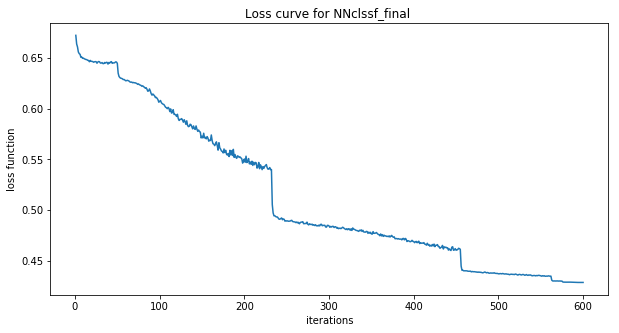

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(NNclssf_final.loss_curve_)
plt.xlabel('iterations')
plt.ylabel('loss function')
plt.title('Loss curve for NNclssf_final ')
plt.show()

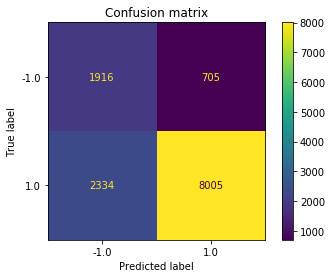


 Recall score = 0.73
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [62]:
otherScores(NNclssf_final,X_test,y_test)

In [66]:
NNclssf_final.score(X_test,y_test)

0.7655092592592593

## Using scaled data

In [71]:
NNclssf_final_scaled = MLPClassifier(hidden_layer_sizes=(25,), learning_rate_init=0.01, learning_rate='adaptive',
                             activation='relu', solver='sgd', max_iter=1000, alpha=0.1, shuffle=True, random_state=0)


NNclssf_final_scaled.fit(X_train_scaled_r,y_train_r)


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

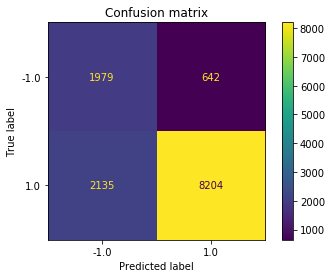


 Recall score = 0.76
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [74]:
otherScores(NNclssf_final_scaled,X_test_scaled,y_test)

In [75]:
NNclssf_final_scaled.score(X_test_scaled,y_test)

0.7857253086419753